In [3]:
import torch, torchvision
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
import torch.functional as F
import numpy as np
import pandas as pd
import torch.utils.data as data
import seaborn as sns
import matplotlib.pyplot as plt

## Skalowanie wyjść wewnątrz sieci - batch norm
Na przykładzie z mini projektu

In [2]:
train_data = pd.read_csv("data.csv",index_col=0)

In [3]:
train = train_data.drop(columns=["casual","registered","cnt","dteday","season","yr","mnth"])
train_dataset = data.TensorDataset(torch.from_numpy(train.values).float(),torch.from_numpy(train_data.values[:,-1].astype(float)).float())

In [4]:
data_loader  = data.DataLoader(train_dataset, batch_size=256, shuffle=True)

In [5]:
class MyNet(nn.Module):
    def __init__(self): 
        super(MyNet, self).__init__()
        self.lin1 = nn.Linear(9, 48) 
        self.act1 = nn.ReLU()
        self.lin2 = nn.Linear(48, 24)
        self.act2 = nn.ReLU()
        self.lin3 = nn.Linear(24, 1)
        
             
    def forward(self, x):
        x = self.lin1(x)
        x = self.act1(x)
        x = self.lin2(x)
        x = self.act2(x)
        x = self.lin3(x)
        return x

In [6]:
class MyNetBN(nn.Module):
    def __init__(self): 
        super().__init__()
        self.lin1 =nn.Linear(9, 48) 
        self.bn1 = nn.BatchNorm1d(48)
        self.act1 =nn.ReLU()
        self.lin2 =nn.Linear(48, 24)
        self.bn2 = nn.BatchNorm1d(24)
        self.act2 =nn.ReLU()
        self.lin3 =nn.Linear(24, 1)
        
             
    def forward(self, x):
        x = self.lin1(x)
        x = self.bn1(x)
        x = self.act1(x)
        x = self.lin2(x)
        x = self.bn2(x)
        x = self.act2(x)
        x = self.lin3(x)
        return x

In [7]:
model = MyNet()
print(model)

MyNet(
  (lin1): Linear(in_features=9, out_features=48, bias=True)
  (act1): ReLU()
  (lin2): Linear(in_features=48, out_features=24, bias=True)
  (act2): ReLU()
  (lin3): Linear(in_features=24, out_features=1, bias=True)
)


In [8]:
model_bn = MyNetBN()
print(model_bn)

MyNetBN(
  (lin1): Linear(in_features=9, out_features=48, bias=True)
  (bn1): BatchNorm1d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU()
  (lin2): Linear(in_features=48, out_features=24, bias=True)
  (bn2): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act2): ReLU()
  (lin3): Linear(in_features=24, out_features=1, bias=True)
)


In [9]:
loss_fn = nn.MSELoss()
opt = optim.SGD(model.parameters(), lr=0.0001, momentum=0.5)
opt_bn = optim.SGD(model_bn.parameters(), lr=0.0001, momentum=0.5)

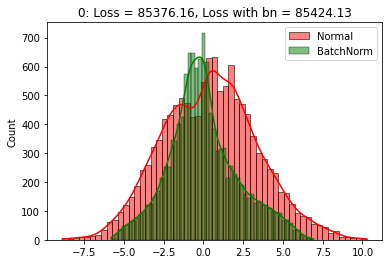

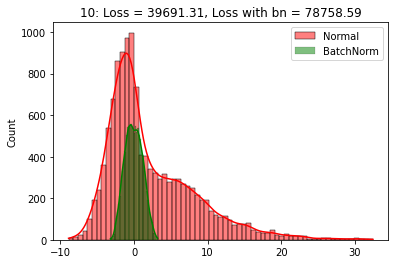

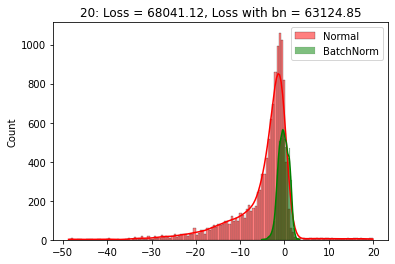

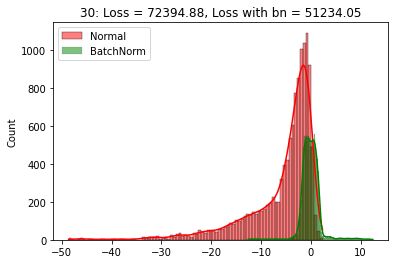

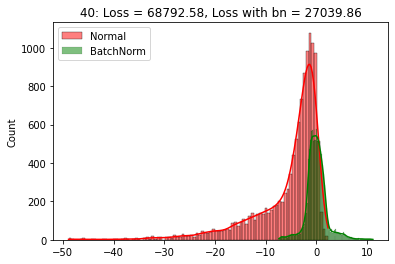

----------------------


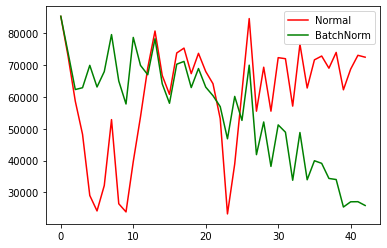

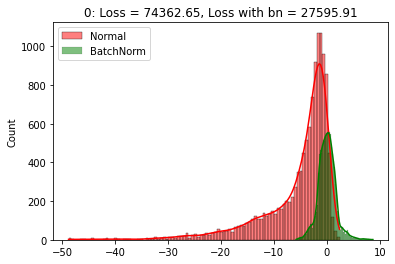

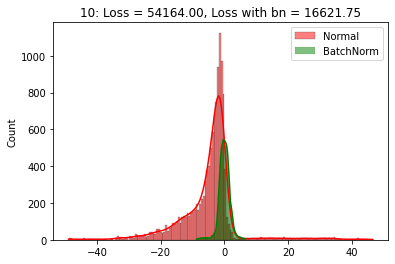

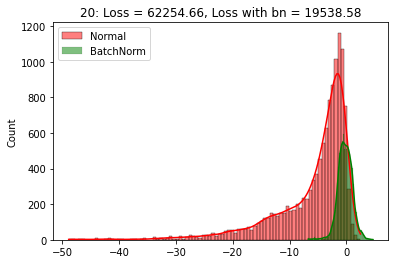

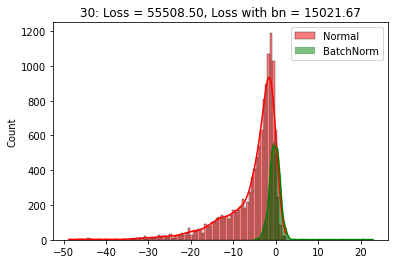

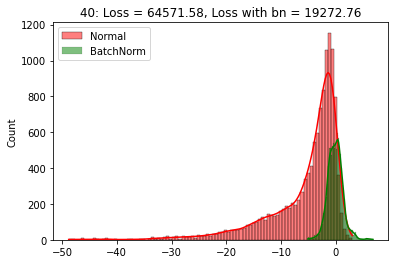

----------------------


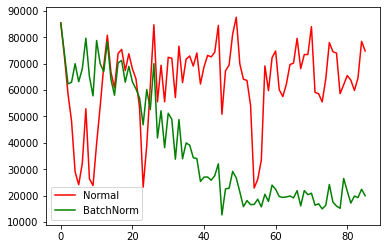

In [10]:
loss_arr = []
loss_bn_arr = []

max_epochs = 2

for epoch in range(max_epochs):
    for i, batch in enumerate(data_loader, 0):

        inputs, labels = batch

        # training steps for normal model
        opt.zero_grad()
        outputs = model(inputs).squeeze()
        loss = loss_fn(outputs, labels)
        loss.backward()
        opt.step()
        
        # training steps for bn model
        opt_bn.zero_grad()
        outputs_bn = model_bn(inputs).squeeze()
        loss_bn = loss_fn(outputs_bn, labels)
        loss_bn.backward()
        opt_bn.step()
        
        loss_arr.append(loss.item())
        loss_bn_arr.append(loss_bn.item())
        
        if i % 10 == 0:
        
            inputs = inputs.view(inputs.size(0), -1)
            
            model.eval()
            model_bn.eval()
            
            a = model.lin1(inputs)
            a = a.detach().numpy().ravel()
            sns.histplot(a, kde=True, color='r', label='Normal') 
            
            b = model_bn.lin1(inputs)
            b = model_bn.bn1(b)
            b = b.detach().numpy().ravel()
            
            sns.histplot(b, kde=True, color='g', label='BatchNorm') 
            plt.title('%d: Loss = %0.2f, Loss with bn = %0.2f' % (i, loss.item(), loss_bn.item()))
            plt.legend()
            plt.show()
            plt.pause(0.5)
            
            model.train()
            model_bn.train()
        
        
    print('----------------------')

    plt.plot(loss_arr, 'r', label='Normal')
    plt.plot(loss_bn_arr, 'g', label='BatchNorm')
    plt.legend()
    plt.show()

## Przeuczanie sieci

In [11]:
mnist_data = torchvision.datasets.MNIST('data', train=True, download=True, transform=transforms.ToTensor())
mnist_data = list(mnist_data)
mnist_train = mnist_data[:20]
mnist_val   = mnist_data[20:1000] 

In [12]:
device = torch.device("cuda:2") 
device

device(type='cuda', index=2)

In [13]:
if torch.cuda.is_available(): 
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)
    
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

In [14]:
class MNISTClassifier(nn.Module):
    def __init__(self):
        super(MNISTClassifier, self).__init__()
        self.layer1 = nn.Linear(28 * 28, 1000)
        self.act_1 =  nn.ReLU()
        self.layer2 = nn.Linear(1000, 1000)
        self.act_2 = nn.ReLU()
        self.layer3 = nn.Linear(1000, 1000)
        self.act_3 = nn.ReLU()
        self.layer4 = nn.Linear(1000, 10)
    def forward(self, img):
        flattened = img.view(-1, 28 * 28)
        activation1 = self.act_1(self.layer1(flattened))
        activation2 = self.act_2(self.layer2(activation1))
        activation3 = self.act_3(self.layer3(activation2))
        output = self.layer4(activation3)
        return output

In [15]:
def train(model, train, valid, batch_size=10, num_epochs=1, learn_rate=0.001, weight_decay=0):
    train_loader = torch.utils.data.DataLoader(train,
                                               batch_size=batch_size,
                                               shuffle=True) # shuffle after every epoch
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(),lr=learn_rate, weight_decay=weight_decay )
#     optimizer = optim.SGD(model.parameters(), lr=learn_rate,momentum=0.9, weight_decay=weight_decay)

    iters, losses, train_acc, val_acc = [], [], [], []

    # training
#     n = 0 # the number of iterations
    idx = 0
    for n in range(num_epochs):
        for imgs, labels in iter(train_loader):
            # imgs, labels = imgs.to(device), labels.to(device)
            model.train() 
            out = model(imgs)             # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         

            # save the current training information
            if idx % 10 == 9:
                iters.append(idx)
                losses.append(float(loss)/batch_size)        # compute *average* loss
                train_acc.append(get_accuracy(model, train)) # compute training accuracy 
                val_acc.append(get_accuracy(model, valid))   # compute validation accuracy
            idx+=1
        if n%100==0:
            print(f"Epoch {n}")

            
    # plotting
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")

    plt.subplot(1,2,2)
    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()


    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))


train_acc_loader = torch.utils.data.DataLoader(mnist_train, batch_size=100)
val_acc_loader = torch.utils.data.DataLoader(mnist_val, batch_size=1000)

def get_accuracy(model, data):
    correct = 0
    total = 0
    model.eval() #*********#
    for imgs, labels in torch.utils.data.DataLoader(data, batch_size=64):
        # imgs, labels = imgs.to(device), labels.to(device)
        output = model(imgs)
        pred = output.max(1, keepdim=True)[1] # get the index of the max logit
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

Epoch 0
Epoch 100


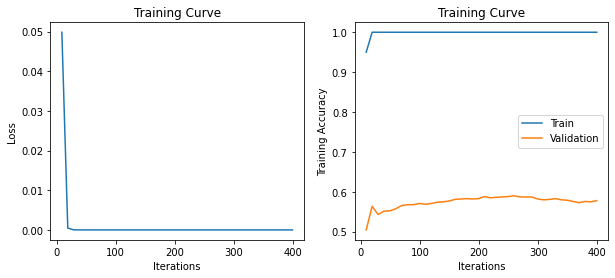

Final Training Accuracy: 1.0
Final Validation Accuracy: 0.5775510204081633


In [16]:
model = MNISTClassifier()
train(model, mnist_train, mnist_val, num_epochs=200)

## Dropout
Maskowanie losowych neuronów w sieci

In [17]:
class MNISTClassifier_Dropout(nn.Module):
    def __init__(self):
        super(MNISTClassifier_Dropout, self).__init__()
        self.layer1 = nn.Linear(28 * 28, 1000)
        self.d1 = nn.Dropout(0.6)
        self.act_1 =  nn.ReLU()
        self.layer2 = nn.Linear(1000, 1000)
        self.d2 = nn.Dropout(0.6)
        self.act_2 = nn.ReLU()
        self.layer3 = nn.Linear(1000, 1000)
        self.d3 = nn.Dropout(0.6)
        self.act_3 = nn.ReLU()
        self.layer4 = nn.Linear(1000, 10)
    def forward(self, img):
        flattened = img.view(-1, 28 * 28)
        activation1 = self.act_1(self.layer1(flattened))
        x = self.d1(activation1)
        activation2 = self.act_2(self.layer2(x))
        x = self.d2(activation2)
        activation3 = self.act_3(self.layer3(x))
        x = self.d2(activation3)
        output = self.layer4(x)
        return output

Epoch 0
Epoch 100


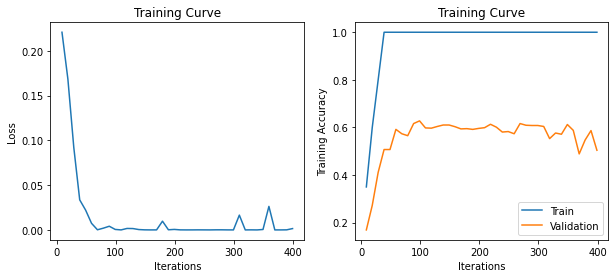

Final Training Accuracy: 1.0
Final Validation Accuracy: 0.5040816326530613


In [18]:
model = MNISTClassifier_Dropout()
train(model, mnist_train, mnist_val, num_epochs=200)

## Weight decay
Regularyzacja zmian wag

Epoch 0
Epoch 100


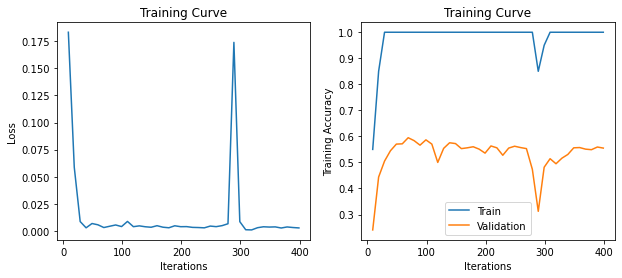

Final Training Accuracy: 1.0
Final Validation Accuracy: 0.5551020408163265


In [19]:
model = MNISTClassifier()
train(model, mnist_train, mnist_val, num_epochs=200, weight_decay=0.02)

## Zadanie - własna regularyzacja

In [20]:
class MNISTClassifier(nn.Module):
    def __init__(self):
        super(MNISTClassifier, self).__init__()
        self.layer1 = nn.Linear(28 * 28, 800)
        self.act_1 =  nn.Tanh()
        self.layer2 = nn.Linear(800, 800)
        self.act_2 = nn.Tanh()
        self.layer3 = nn.Linear(800, 10)
    def forward(self, img):
        flattened = img.view(-1, 28 * 28)
        activation1 = self.act_1(self.layer1(flattened))
        activation2 = self.act_2(self.layer2(activation1))
        output = self.layer3(activation2)
        return output

In [21]:
model = MNISTClassifier()
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=10, shuffle=True) # shuffle after every epoch
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

Epoch 0
Epoch 100
Epoch 200
Epoch 300
Epoch 400
Epoch 500
Epoch 600
Epoch 700
Epoch 800
Epoch 900


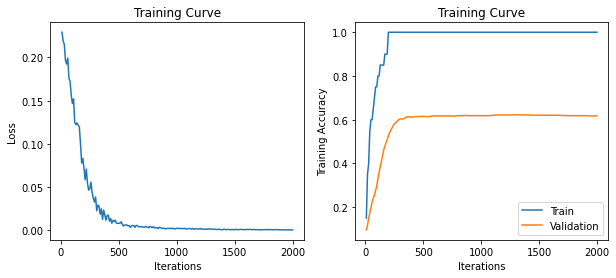

Final Training Accuracy: 1.0
Final Validation Accuracy: 0.6183673469387755


In [22]:
iters, losses, train_acc, val_acc = [], [], [], []

idx = 0
for n in range(1000):
    for imgs, labels in iter(train_loader):
        # imgs, labels = imgs.to(device), labels.to(device)
        model.train() 
        out = model(imgs)             
        ###### 
        # Here propose some form of regularization 
        # HINT model.layer1 or list(model.parameters())
        
        regularization = 0
        
        ######
        loss = criterion(out, labels) + regularization # compute the total loss as a sum of loss + regularization
        loss.backward()               
        optimizer.step()              
        optimizer.zero_grad()         


        if idx % 10 == 9:
            iters.append(idx)
            losses.append(float(loss)/10)        # compute *average* loss
            train_acc.append(get_accuracy(model, mnist_train)) # compute training accuracy 
            val_acc.append(get_accuracy(model, mnist_val))   # compute validation accuracy
        idx+=1
    if n%100==0:
        print(f"Epoch {n}")

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.title("Training Curve")
plt.plot(iters, losses, label="Train")
plt.xlabel("Iterations")
plt.ylabel("Loss")

plt.subplot(1,2,2)
plt.title("Training Curve")
plt.plot(iters, train_acc, label="Train")
plt.plot(iters, val_acc, label="Validation")
plt.xlabel("Iterations")
plt.ylabel("Training Accuracy")
plt.legend(loc='best')
plt.show()


print("Final Training Accuracy: {}".format(train_acc[-1]))
print("Final Validation Accuracy: {}".format(val_acc[-1]))

In [23]:
def train(model, train, valid, batch_size=10, num_epochs=1, learn_rate=0.001, weight_decay=0):
    train_loader = torch.utils.data.DataLoader(train,
                                               batch_size=batch_size,
                                               shuffle=True) # shuffle after every epoch
    criterion = nn.CrossEntropyLoss()
#     optimizer = optim.Adam(model.parameters(),lr=learn_rate, weight_decay=weight_decay )
    optimizer = optim.SGD(model.parameters(), lr=learn_rate,momentum=0.9, weight_decay=weight_decay)

    iters, losses, train_acc, val_acc = [], [], [], []

    # training
#     n = 0 # the number of iterations
    idx = 0
    for n in range(num_epochs):
        for imgs, labels in iter(train_loader):
            # imgs, labels = imgs.to(device), labels.to(device)
            model.train() 
            out = model(imgs)             # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         

            # save the current training information
            if idx % 10 == 9:
                iters.append(idx)
                losses.append(float(loss)/batch_size)        # compute *average* loss
                train_acc.append(get_accuracy(model, train)) # compute training accuracy 
                val_acc.append(get_accuracy(model, valid))   # compute validation accuracy
            idx+=1
        if n%100==0:
            print(f"Epoch {n}")

            
    # plotting
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")

    plt.subplot(1,2,2)
    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()


    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))


train_acc_loader = torch.utils.data.DataLoader(mnist_train, batch_size=100)
val_acc_loader = torch.utils.data.DataLoader(mnist_val, batch_size=1000)

def get_accuracy(model, data):
    correct = 0
    total = 0
    model.eval() #*********#
    for imgs, labels in torch.utils.data.DataLoader(data, batch_size=64):
        # imgs, labels = imgs.to(device), labels.to(device)
        output = model(imgs)
        pred = output.max(1, keepdim=True)[1] # get the index of the max logit
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

# Wielkość sieci a jej jakość

In [24]:
class MNISTClassifier_parametrized(nn.Module):
    def __init__(self,size_1,size_2):
        super(MNISTClassifier_parametrized, self).__init__()
        self.layer1 = nn.Linear(28 * 28, size_1)
        self.act_1 =  nn.Tanh()
        self.layer2 = nn.Linear(size_1, size_2)
        self.act_2 = nn.Tanh()
        self.layer3 = nn.Linear(size_2, 10)
    def forward(self, img):
        flattened = img.view(-1, 28 * 28)
        activation1 = self.act_1(self.layer1(flattened))
        activation2 = self.act_2(self.layer2(activation1))
        output = self.layer3(activation2)
        return output

Epoch 0
Epoch 100
Epoch 200
Epoch 300
Epoch 400
Epoch 500
Epoch 600
Epoch 700
Epoch 800
Epoch 900


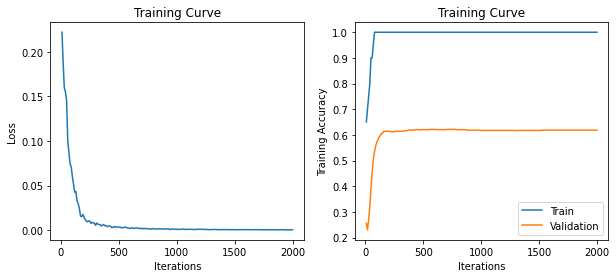

Final Training Accuracy: 1.0
Final Validation Accuracy: 0.6183673469387755


In [25]:
model = MNISTClassifier_parametrized(5000,3000)
train(model, mnist_train, mnist_val, num_epochs=1000)

Epoch 0
Epoch 100
Epoch 200
Epoch 300
Epoch 400
Epoch 500
Epoch 600
Epoch 700
Epoch 800
Epoch 900


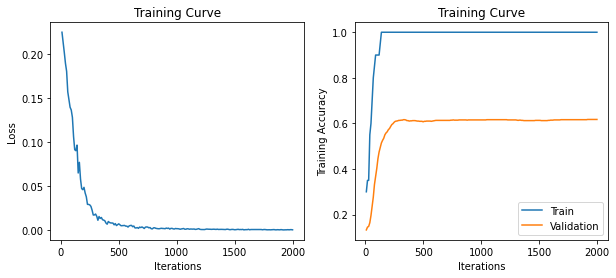

Final Training Accuracy: 1.0
Final Validation Accuracy: 0.6173469387755102


In [26]:
model = MNISTClassifier_parametrized(2000,1000)
train(model, mnist_train, mnist_val, num_epochs=1000)

Epoch 0
Epoch 100
Epoch 200
Epoch 300
Epoch 400
Epoch 500
Epoch 600
Epoch 700
Epoch 800
Epoch 900


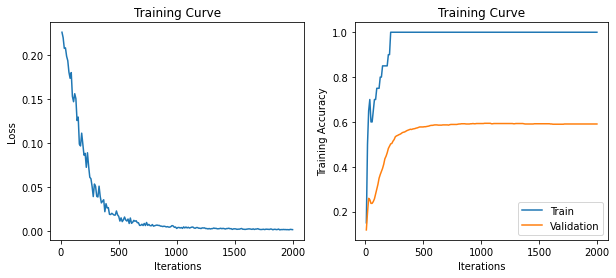

Final Training Accuracy: 1.0
Final Validation Accuracy: 0.5908163265306122


In [27]:
model = MNISTClassifier_parametrized(1000,100)
train(model, mnist_train, mnist_val, num_epochs=1000)

Epoch 0
Epoch 100
Epoch 200
Epoch 300
Epoch 400
Epoch 500
Epoch 600
Epoch 700
Epoch 800
Epoch 900


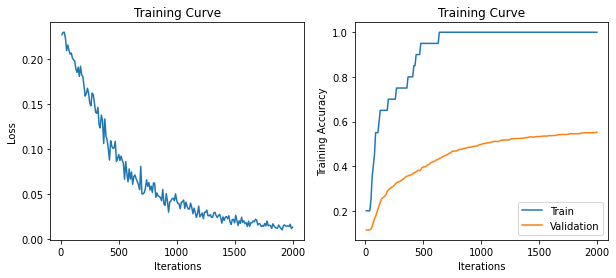

Final Training Accuracy: 1.0
Final Validation Accuracy: 0.5520408163265306


In [28]:
model = MNISTClassifier_parametrized(20,10)
train(model, mnist_train, mnist_val, num_epochs=1000)

Epoch 0
Epoch 100
Epoch 200
Epoch 300
Epoch 400
Epoch 500
Epoch 600
Epoch 700
Epoch 800
Epoch 900
Epoch 1000
Epoch 1100
Epoch 1200
Epoch 1300
Epoch 1400
Epoch 1500
Epoch 1600
Epoch 1700
Epoch 1800
Epoch 1900
Epoch 2000
Epoch 2100
Epoch 2200
Epoch 2300
Epoch 2400
Epoch 2500
Epoch 2600
Epoch 2700
Epoch 2800
Epoch 2900
Epoch 3000
Epoch 3100
Epoch 3200
Epoch 3300
Epoch 3400
Epoch 3500
Epoch 3600
Epoch 3700
Epoch 3800
Epoch 3900
Epoch 4000
Epoch 4100
Epoch 4200
Epoch 4300
Epoch 4400
Epoch 4500
Epoch 4600
Epoch 4700
Epoch 4800
Epoch 4900


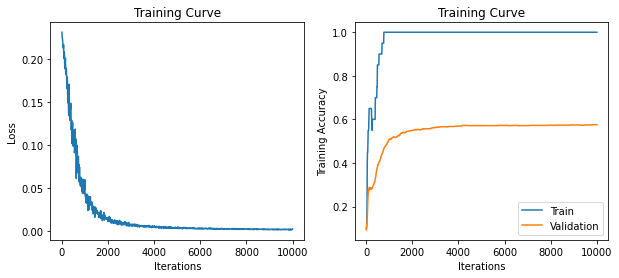

Final Training Accuracy: 1.0
Final Validation Accuracy: 0.5755102040816327


In [29]:
model = MNISTClassifier_parametrized(20,10)
train(model, mnist_train, mnist_val, num_epochs=5000)

# Przeszukiwanie hiperparametrów
Uwaga, wykonanie poniższych komórek może zająć sporo czasu

In [30]:
def fast_accuracy(model, data):
    with torch.no_grad():
        correct = 0
        total = 0
        model.eval()
        imgs, labels = data
        output = model(imgs)
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

def train_search(model, train, valid, batch_size=10, num_epochs=1, learn_rate=0.001, weight_decay=0):
    train_loader = torch.utils.data.DataLoader(train,
                                               batch_size=batch_size,
                                               shuffle=True) # shuffle after every epoch
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learn_rate,momentum=0.9, weight_decay=weight_decay)

    iters, losses, train_acc, val_acc = [], [], [], []

    idx = 0
    for n in range(num_epochs):
        for imgs, labels in iter(train_loader):
            # imgs, labels = imgs.to(device), labels.to(device)
            model.train()
            out = model(imgs)            
            loss = criterion(out, labels) 
            loss.backward()               
            optimizer.step()              
            optimizer.zero_grad()         

    return(fast_accuracy(model, valid))

In [31]:
mnist_val_preprocessed = torch.cat([batch[0] for batch in mnist_val]), torch.tensor([batch[1] for batch in mnist_val])
mnist_data = torchvision.datasets.MNIST('data', train=True, download=True, transform=transforms.ToTensor())
mnist_data = list(mnist_data)
mnist_train = mnist_data[:20]
mnist_val   = mnist_data[20:10000] 

In [33]:
first_layer = [20000, 10000, 5000, 2000, 1000, 500, 100, 50, 10]
second_layer = [20000, 10000, 5000, 2000, 1000, 500, 100, 50, 10]
results = pd.DataFrame()
for i in range(len(first_layer)):
    for j in range(len(second_layer)):
        model = MNISTClassifier_parametrized(first_layer[i],second_layer[j])
        val_acc = train_search(model, mnist_train, mnist_val_preprocessed, num_epochs=1000)
        print(first_layer[i],second_layer[j],val_acc)
        results = results.append({"first": first_layer[i], "second": second_layer[j],"acc":val_acc},ignore_index=True)

KeyboardInterrupt: 

In [ ]:
#results.to_csv("params_search.csv",index=False)
results = pd.read_csv("params_search.csv")

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(results["first"], results["second"], c=np.exp(results.acc*100), cmap="YlGn", s=1000)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("First layer")
plt.ylabel("Second layer")
for idx, row in results.iterrows():
    ax.annotate(str(row.acc)[:5], (row["first"]*0.82, row["second"]))
plt.show()

In [34]:
class MNISTClassifier_parametrized_3(nn.Module):
    def __init__(self,size_1,size_2, size_3):
        super(MNISTClassifier_parametrized_3, self).__init__()
        self.layer1 = nn.Linear(28 * 28, size_1)
        self.act_1 =  nn.Tanh()
        self.layer2 = nn.Linear(size_1, size_2)
        self.act_2 = nn.Tanh()
        self.layer3 = nn.Linear(size_2, size_3)
        self.act_3 = nn.Tanh()
        self.layer4 = nn.Linear(size_3, 10)
    def forward(self, img):
        flattened = img.view(-1, 28 * 28)
        activation1 = self.act_1(self.layer1(flattened))
        activation2 = self.act_2(self.layer2(activation1))
        activation3 = self.act_3(self.layer3(activation2))
        output = self.layer4(activation3)
        return output

## Sieć o większej liczbie warstw wymaga dłuższego treningu

Epoch 0
Epoch 100
Epoch 200


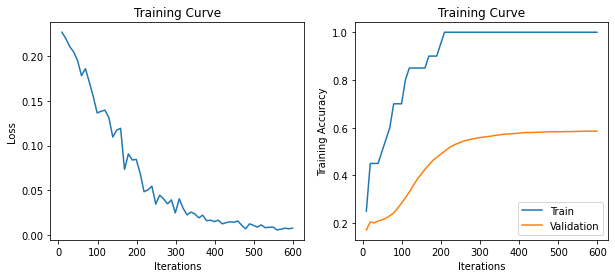

Final Training Accuracy: 1.0
Final Validation Accuracy: 0.5856713426853707


In [35]:
model = MNISTClassifier_parametrized(1000,500)
train(model, mnist_train, mnist_val, num_epochs=300)

Epoch 0
Epoch 100
Epoch 200


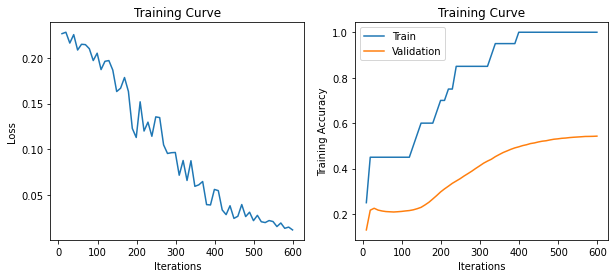

Final Training Accuracy: 1.0
Final Validation Accuracy: 0.5427855711422845


In [36]:
model = MNISTClassifier_parametrized_3(1000,500,100)
train(model, mnist_train, mnist_val, num_epochs=300)

## Większa liczba warstw może prowadzić do przeuczania

Epoch 0
Epoch 100
Epoch 200
Epoch 300
Epoch 400
Epoch 500
Epoch 600
Epoch 700
Epoch 800
Epoch 900
Epoch 1000
Epoch 1100
Epoch 1200
Epoch 1300
Epoch 1400
Epoch 1500
Epoch 1600
Epoch 1700
Epoch 1800
Epoch 1900
Epoch 2000
Epoch 2100
Epoch 2200
Epoch 2300
Epoch 2400
Epoch 2500
Epoch 2600
Epoch 2700
Epoch 2800
Epoch 2900


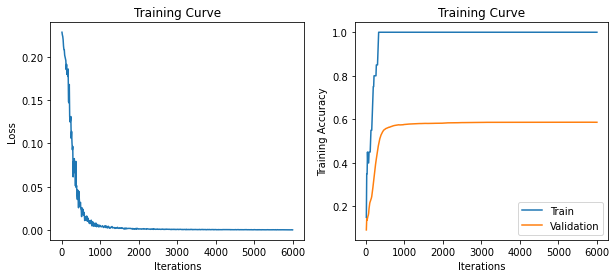

Final Training Accuracy: 1.0
Final Validation Accuracy: 0.5865731462925852


In [37]:
model = MNISTClassifier_parametrized_3(1000,500,100)
train(model, mnist_train, mnist_val, num_epochs=3000)

Epoch 0
Epoch 100
Epoch 200
Epoch 300
Epoch 400
Epoch 500
Epoch 600
Epoch 700
Epoch 800
Epoch 900
Epoch 1000
Epoch 1100
Epoch 1200
Epoch 1300
Epoch 1400
Epoch 1500
Epoch 1600
Epoch 1700
Epoch 1800
Epoch 1900
Epoch 2000
Epoch 2100
Epoch 2200
Epoch 2300
Epoch 2400
Epoch 2500
Epoch 2600
Epoch 2700
Epoch 2800
Epoch 2900


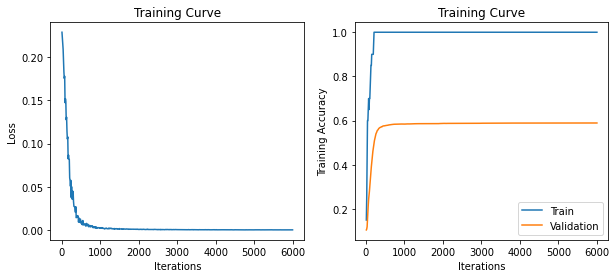

Final Training Accuracy: 1.0
Final Validation Accuracy: 0.5892785571142285


In [38]:
model = MNISTClassifier_parametrized(1000,500)
train(model, mnist_train, mnist_val, num_epochs=3000)

# Reprezentacja danych

In [8]:
adults_data_orig = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",header=None)

In [9]:
adults_data = adults_data_orig.copy()

In [10]:
adults_data.columns = ["age", "workclass", "fnlwgt", "education", "education-num", "marital-status", "occupation", "relationship", "race", "sex", "capital-gain", "capital-loss", "hours-per-week", "native-country", "label"]

In [11]:
adults_data

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,label
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


In [12]:
adults_data.drop(columns=["native-country","education","workclass","relationship", "marital-status","race"],inplace=True)

In [13]:
adults_data

,age,fnlwgt,education-num,occupation,sex,capital-gain,capital-loss,hours-per-week,label
0,39,77516,13,Adm-clerical,Male,2174,0,40,<=50K
1,50,83311,13,Exec-managerial,Male,0,0,13,<=50K
2,38,215646,9,Handlers-cleaners,Male,0,0,40,<=50K
3,53,234721,7,Handlers-cleaners,Male,0,0,40,<=50K
4,28,338409,13,Prof-specialty,Female,0,0,40,<=50K
...,...,...,...,...,...,...,...,...,...
32556,27,257302,12,Tech-support,Female,0,0,38,<=50K
32557,40,154374,9,Machine-op-inspct,Male,0,0,40,>50K
32558,58,151910,9,Adm-clerical,Female,0,0,40,<=50K
32559,22,201490,9,Adm-clerical,Male,0,0,20,<=50K


In [14]:
adults_data.sex = (adults_data.sex==' Male').astype(int)
adults_data.label = (adults_data.label==' >50K').astype(int)

In [15]:
categorical_columns = ["occupation"]
categorical_values = pd.get_dummies(adults_data[categorical_columns])
categorical_values.head()

,occupation_ ?,occupation_ Adm-clerical,occupation_ Armed-Forces,occupation_ Craft-repair,occupation_ Exec-managerial,occupation_ Farming-fishing,occupation_ Handlers-cleaners,occupation_ Machine-op-inspct,occupation_ Other-service,occupation_ Priv-house-serv,occupation_ Prof-specialty,occupation_ Protective-serv,occupation_ Sales,occupation_ Tech-support,occupation_ Transport-moving
0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [16]:
adults_data.drop(columns=categorical_columns,inplace=True)

In [17]:
train_indices = np.random.rand(len(adults_data))>0.3

In [31]:
train_indices

array([False,  True,  True, ...,  True,  True,  True])

In [18]:
numerical_data = torch.from_numpy(adults_data.values[train_indices,:-1]).float()
categorical_data = torch.from_numpy(categorical_values.values[train_indices]).float()
targets = torch.from_numpy(adults_data.values[train_indices,-1]).float()

test_numerical_data = torch.from_numpy(adults_data.values[~train_indices,:-1]).float()
test_categorical_data = torch.from_numpy(categorical_values.values[~train_indices]).float()
test_targets = torch.from_numpy(adults_data.values[~train_indices,-1]).float()

In [30]:
categorical_data

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [19]:
train_dataset = data.TensorDataset(numerical_data,categorical_data,targets)
test_dataset = data.TensorDataset(test_numerical_data,test_categorical_data,test_targets)

In [20]:
class Adults_classifier(nn.Module):
    def __init__(self):
        super(Adults_classifier, self).__init__()
        self.layer1 = nn.Linear(adults_data.shape[1] + categorical_data.shape[1] -1, 40)
        self.act_1 = nn.LeakyReLU()
        self.d1 = nn.Dropout(0.4)
        self.layer2 = nn.Linear(40, 20)
        self.act_2 = nn.LeakyReLU()
        self.d2 = nn.Dropout(0.4)
        self.layer3 = nn.Linear(20, 1)
    def forward(self, x, cat_x):
        x = torch.cat([x,cat_x],dim=1)
        activation1 = self.act_1(self.layer1(x))
        activation1 = self.d1(activation1)
        activation2 = self.act_2(self.layer2(activation1))
        activation2 = self.d1(activation2)
        output = self.layer3(activation2)
        return output

In [21]:
def get_accuracy(model, data_loader):
    correct = 0
    total = 0
    model.eval() #*********#
    for x, cat_x, labels in data_loader:
        x, cat_x, labels = x, cat_x, labels
        output = model(x, cat_x)
        pred = output>0
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += x.shape[0]
    return correct / total

In [22]:
model = Adults_classifier()
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

iters = []
losses = []
train_acc = []
val_acc = []
for n in range(10):
    epoch_losses = []
    for x, cat_x, labels in iter(train_loader):
        # x, cat_x, labels = x.to(device), cat_x.to(device), labels.to(device)
        model.train() 
        out = model(x, cat_x).squeeze()           

        loss = criterion(out, labels)
        loss.backward()  
        epoch_losses.append(loss.item())
        optimizer.step()              
        optimizer.zero_grad()         

    loss_mean = np.array(epoch_losses).mean()
    iters.append(n)
    losses.append(loss_mean)
    test_acc = get_accuracy(model, test_loader)
    print(f"Epoch {n} loss {loss_mean:.3} test_acc: {test_acc:.3}")
    train_acc.append(get_accuracy(model, train_loader)) # compute training accuracy 
    val_acc.append(test_acc)  # compute validation accuracy
        

print("Final Training Accuracy: {}".format(train_acc[-1]))
print("Final Validation Accuracy: {}".format(val_acc[-1]))

Epoch 0 loss 98.4 test_acc: 0.761
Epoch 1 loss 12.0 test_acc: 0.765
Epoch 2 loss 4.6 test_acc: 0.765
Epoch 3 loss 1.11 test_acc: 0.761
Epoch 4 loss 0.623 test_acc: 0.761
Epoch 5 loss 0.607 test_acc: 0.761
Epoch 6 loss 0.6 test_acc: 0.761
Epoch 7 loss 0.597 test_acc: 0.761
Epoch 8 loss 0.602 test_acc: 0.761
Epoch 9 loss 0.591 test_acc: 0.761
Final Training Accuracy: 0.7585395608225862
Final Validation Accuracy: 0.7607451347694869


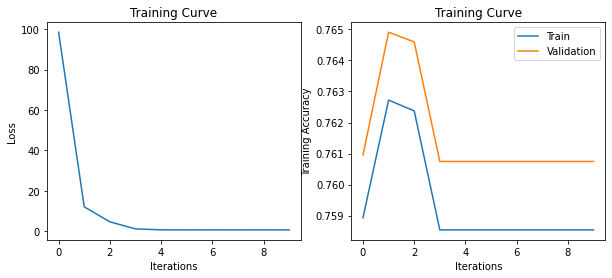

In [23]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.title("Training Curve")
plt.plot(iters, losses, label="Train")
plt.xlabel("Iterations")
plt.ylabel("Loss")

plt.subplot(1,2,2)
plt.title("Training Curve")
plt.plot(iters, train_acc, label="Train")
plt.plot(iters, val_acc, label="Validation")
plt.xlabel("Iterations")
plt.ylabel("Training Accuracy")
plt.legend(loc='best')
plt.show()

## Embeddingi

In [24]:
class Adults_classifier_embeddings(nn.Module):
    def __init__(self):
        super(Adults_classifier_embeddings, self).__init__()
        self.emb_layer = nn.Linear(categorical_data.shape[1], categorical_data.shape[1])
        self.act_emb = nn.Tanh()
        self.layer1 = nn.Linear(adults_data.shape[1] -1 + categorical_data.shape[1], 40)
        self.act_1 =  nn.LeakyReLU()
        self.d1 = nn.Dropout(0.4)
        self.layer2 = nn.Linear(40, 20)
        self.act_2 =  nn.LeakyReLU()
        self.d2 = nn.Dropout(0.4)
        self.layer3 = nn.Linear(20, 1)
    def forward(self, x, cat_x):
        cat_x_embedded = self.emb_layer(cat_x)
        cat_x_embedded = self.act_emb(cat_x_embedded)
        x = torch.cat([x,cat_x_embedded],dim=1)
        activation1 = self.act_1(self.layer1(x))
        activation1 = self.d1(activation1)
        activation2 = self.act_2(self.layer2(activation1))
        activation2 = self.d2(activation2)
        output = self.layer3(activation2)
        return output

In [25]:
model = Adults_classifier_embeddings()
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [29]:
next(iter(train_dataset))

(tensor([5.0000e+01, 8.3311e+04, 1.3000e+01, 1.0000e+00, 0.0000e+00, 0.0000e+00,
         1.3000e+01]),
 tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 tensor(0.))

In [34]:
iters = []
losses = []
train_acc = []
val_acc = []
for n in range(10):
    epoch_losses = []
    for x, cat_x, labels in iter(train_loader):
        # x, cat_x, labels = x.to(device), cat_x.to(device), labels.to(device)
        model.train() 
        out = model(x, cat_x).squeeze()           
        # print('OUT', out)
        loss = criterion(out, labels)
        loss.backward()  
        epoch_losses.append(loss.item())
        optimizer.step()              
        optimizer.zero_grad()         

    loss_mean = np.array(epoch_losses).mean()
    iters.append(n)
    losses.append(loss_mean)
    test_acc = get_accuracy(model, test_loader)
    print(f"Epoch {n} loss {loss_mean:.3} test_acc: {test_acc:.3}")
    train_acc.append(get_accuracy(model, train_loader)) # compute training accuracy 
    val_acc.append(test_acc)  # compute validation accuracy
        

print("Final Training Accuracy: {}".format(train_acc[-1]))
print("Final Validation Accuracy: {}".format(val_acc[-1]))

Epoch 0 loss 0.579 test_acc: 0.765
Epoch 1 loss 0.569 test_acc: 0.767
Epoch 2 loss 0.565 test_acc: 0.768
Epoch 3 loss 0.568 test_acc: 0.769
Epoch 4 loss 0.561 test_acc: 0.772
Epoch 5 loss 0.562 test_acc: 0.775
Epoch 6 loss 0.544 test_acc: 0.778
Epoch 7 loss 0.532 test_acc: 0.793
Epoch 8 loss 0.526 test_acc: 0.777
Epoch 9 loss 0.524 test_acc: 0.793
Final Training Accuracy: 0.7946148483792262
Final Validation Accuracy: 0.7934228327609533


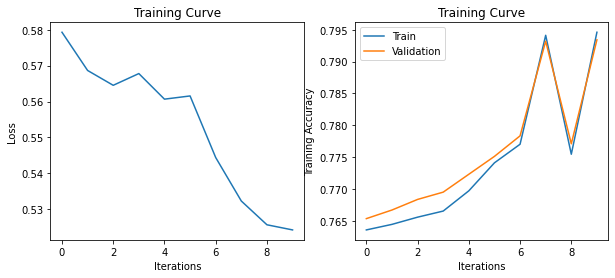

In [35]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.title("Training Curve")
plt.plot(iters, losses, label="Train")
plt.xlabel("Iterations")
plt.ylabel("Loss")

plt.subplot(1,2,2)
plt.title("Training Curve")
plt.plot(iters, train_acc, label="Train")
plt.plot(iters, val_acc, label="Validation")
plt.xlabel("Iterations")
plt.ylabel("Training Accuracy")
plt.legend(loc='best')
plt.show()

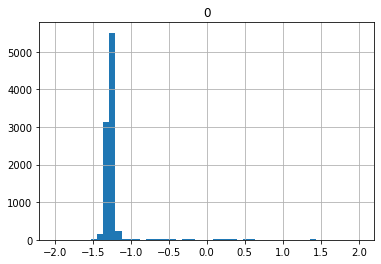

In [36]:
preds = model(test_numerical_data,test_categorical_data)
pd.DataFrame(preds.cpu().detach().numpy()).hist(bins=50, range=(-2,2));

In [37]:
(preds>0).sum()

tensor(378)

# Ważenie przykładów

In [60]:
model = Adults_classifier_embeddings()
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)
criterion = nn.BCEWithLogitsLoss(pos_weight=(len(targets)-sum(targets))/sum(targets))
optimizer = optim.Adam(model.parameters(), lr=0.001)

iters = []
losses = []
train_acc = []
val_acc = []
for n in range(10):
    epoch_losses = []
    for x, cat_x, labels in iter(train_loader):
        # x, cat_x, labels = x.to(device), cat_x.to(device), labels.to(device)
        model.train() 
        out = model(x, cat_x).squeeze()           

        loss = criterion(out, labels)
        loss.backward()  
        epoch_losses.append(loss.item())
        optimizer.step()              
        optimizer.zero_grad()         

    loss_mean = np.array(epoch_losses).mean()
    iters.append(n)
    losses.append(loss_mean)
    test_acc = get_accuracy(model, test_loader)
    print(f"Epoch {n} loss {loss_mean:.3} test_acc: {test_acc:.3}")
    train_acc.append(get_accuracy(model, train_loader)) # compute training accuracy 
    val_acc.append(test_acc)  # compute validation accuracy
        

print("Final Training Accuracy: {}".format(train_acc[-1]))
print("Final Validation Accuracy: {}".format(val_acc[-1]))

Epoch 0 loss 4.93e+02 test_acc: 0.241
Epoch 1 loss 27.7 test_acc: 0.31
Epoch 2 loss 16.9 test_acc: 0.351
Epoch 3 loss 11.2 test_acc: 0.788
Epoch 4 loss 6.56 test_acc: 0.798
Epoch 5 loss 4.23 test_acc: 0.679
Epoch 6 loss 2.65 test_acc: 0.8
Epoch 7 loss 1.9 test_acc: 0.8
Epoch 8 loss 1.48 test_acc: 0.79
Epoch 9 loss 1.24 test_acc: 0.752
Final Training Accuracy: 0.7521236535598563
Final Validation Accuracy: 0.7521341149850869


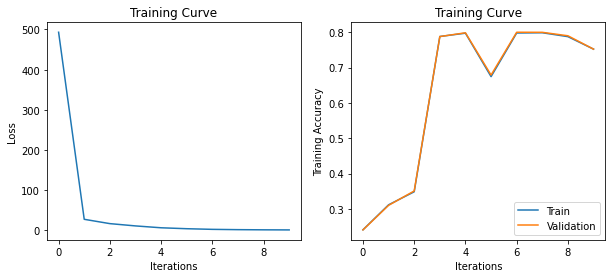

In [61]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.title("Training Curve")
plt.plot(iters, losses, label="Train")
plt.xlabel("Iterations")
plt.ylabel("Loss")

plt.subplot(1,2,2)
plt.title("Training Curve")
plt.plot(iters, train_acc, label="Train")
plt.plot(iters, val_acc, label="Validation")
plt.xlabel("Iterations")
plt.ylabel("Training Accuracy")
plt.legend(loc='best')
plt.show()

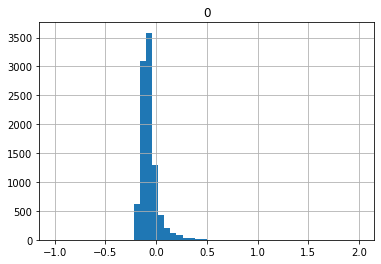

In [62]:
preds = model(test_numerical_data,test_categorical_data)
pd.DataFrame(preds.cpu().detach().numpy()).hist(bins=50, range=(-1,2));

In [63]:
(preds>0).sum()

tensor(1481)

# Zadanie domowe
Dokończ pracę nad modelem dla predykcji zarobków (uwzględniając pozostałe kolumny, grupując je w embeddingi, ważąc klasy itp.)